In [16]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda

In [17]:
from keras.utils import normalize
import os
import glob
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt

In [18]:
import glob
import os
import rasterio

In [19]:
train_nir="D:/Acres/January 2025/Assignment 8/AgriculturalField-Seg/train/original_train"
train_mask="D:/Acres/January 2025/Assignment 8/AgriculturalField-Seg/train/groundtruth_train"

In [20]:
# Define the data loading function
def load_data(image_dir, mask_dir, image_size=(256, 256)):
    """Load images and masks, resize them, and normalize."""
    images = []
    masks = []
    
    # Load images
    for img_file in sorted(os.listdir(image_dir)):
        img_path = os.path.join(image_dir, img_file)
        img = tf.keras.utils.load_img(img_path, target_size=image_size)
        img = tf.keras.utils.img_to_array(img) / 255.0  # Normalize to [0, 1]
        images.append(img)
    
    # Load masks
    for mask_file in sorted(os.listdir(mask_dir)):
        mask_path = os.path.join(mask_dir, mask_file)
        mask = tf.keras.utils.load_img(mask_path, target_size=image_size, color_mode="grayscale")
        mask = tf.keras.utils.img_to_array(mask)
        mask = mask / 255  # Normalize mask to [0, 1]
        mask = np.squeeze(mask)  # Remove single channel
        mask = mask.astype(int)  # Convert mask to integer type
        mask = to_categorical(mask, num_classes=2)  # Convert to one-hot encoding
        masks.append(mask)
    
    return np.array(images), np.array(masks)


In [21]:
# Define the dice loss function
def dice_loss(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    denominator = tf.reduce_sum(y_true + y_pred, axis=[1, 2, 3])
    return 1 - (numerator + 1) / (denominator + 1)

In [22]:
# Define the model creation function
def create_deeplabv3plus(input_shape=(256, 256, 3), num_classes=2):
    """Build a DeepLabV3+ model with ResNet50 backbone."""
    base_model = tf.keras.applications.ResNet50(input_shape=input_shape, include_top=False)
    base_model.trainable = False  # Freeze during initial training

    # Extract high-level and low-level features
    high_level_features = base_model.get_layer("conv4_block6_out").output
    high_level_features = tf.keras.layers.Conv2D(256, (1, 1), activation="relu")(high_level_features)

    low_level_features = base_model.get_layer("conv2_block3_out").output
    low_level_features = tf.keras.layers.Conv2D(48, (1, 1), activation="relu")(low_level_features)

    # Upsample and concatenate
    x = tf.keras.layers.UpSampling2D(size=(4, 4), interpolation="bilinear")(high_level_features)
    x = tf.keras.layers.Concatenate()([x, low_level_features])
    x = tf.keras.layers.Conv2D(256, (3, 3), padding="same", activation="relu")(x)
    x = tf.keras.layers.UpSampling2D(size=(4, 4), interpolation="bilinear")(x)

    # Output layer
    outputs = tf.keras.layers.Conv2D(num_classes, (1, 1), activation="softmax")(x)

    return tf.keras.Model(inputs=base_model.input, outputs=outputs)

In [26]:
# Main training function
def train_model():
    # Define the paths to your image and mask directories
    image_dir = "D:/Acres/January 2025/Assignment 8/AgriculturalField-Seg/train/original_train"  # Replace with actual path
    mask_dir = "D:/Acres/January 2025/Assignment 8/AgriculturalField-Seg/train/groundtruth_train"  # Replace with actual path
    
    # Load dataset
    X, Y = load_data(image_dir, mask_dir)
    
    # Split into train and validation sets
    split_idx = int(0.8 * len(X))
    X_train, X_val = X[:split_idx], X[split_idx:]
    Y_train, Y_val = Y[:split_idx], Y[split_idx:]
    
    # Create model
    model = create_deeplabv3plus(input_shape=(256, 256, 3), num_classes=2)
    model.summary()
    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss="categorical_crossentropy", metrics=["accuracy"])
    
    # Train the model
    history = model.fit(
        X_train, Y_train,
        validation_data=(X_val, Y_val),
        batch_size=16,
        epochs=10
    )
    
    # Save the model
    model.save("deeplabv3plus_improved_bund_segmentation.h5")
    
    # Plot the training history
    plt.plot(history.history['accuracy'], label='Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.show()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 262,  │          0 │ input_layer_4[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 64,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 64, 64,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 64, 64,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_3_c

 Total params: 9,565,106 (36.49 MB)

 Trainable params: 975,922 (3.72 MB)

 Non-trainable params: 8,589,184 (32.77 MB)

Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 325s 7s/step - accuracy: 0.9425 - loss: 0.2309 - val_accuracy: 0.9475 - val_loss: 0.2083
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 284s 6s/step - accuracy: 0.9407 - loss: 0.2251 - val_accuracy: 0.9475 - val_loss: 0.2051
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 280s 6s/step - accuracy: 0.9411 - loss: 0.2224 - val_accuracy: 0.9475 - val_loss: 0.2045
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 283s 6s/step - accuracy: 0.9415 - loss: 0.2207 - val_accuracy: 0.9475 - val_loss: 0.2034
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 283s 6s/step - accuracy: 0.9418 - loss: 0.2187 - val_accuracy: 0.9475 - val_loss: 0.2041
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 284s 6s/step - accuracy: 0.9410 - loss: 0.2203 - val_accuracy: 0.9475 - val_loss: 0.2019
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 283s 6s/step - accuracy: 0.9410 - loss: 0.2198 - val_accuracy: 0.9475 - val_loss: 0.2010
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 282s 6s/step - accuracy: 0.9407 - loss: 0.2206 - val_accuracy: 0.9475 - v

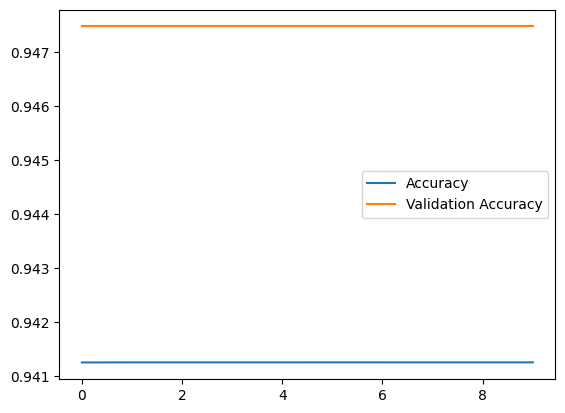

In [27]:
# Run the training process
if __name__ == "__main__":
    train_model()

In [31]:
# Define the paths to your image and mask directories
image_dir = "D:/Acres/January 2025/Assignment 8/AgriculturalField-Seg/train/original_train"  # Replace with actual path
mask_dir = "D:/Acres/January 2025/Assignment 8/AgriculturalField-Seg/train/groundtruth_train"  # Replace with actual path

# Load dataset
X, Y = load_data(image_dir, mask_dir)

# Split into train and validation sets
split_idx = int(0.8 * len(X))
X_train, X_val = X[:split_idx], X[split_idx:]
Y_train, Y_val = Y[:split_idx], Y[split_idx:]

In [35]:
import random

def show_random_predictions(model, X_val, Y_val, num_samples=5):
    """Display random images from the validation set with true and predicted masks."""
    indices = random.sample(range(len(X_val)), num_samples)  # Select random indices
    for i, idx in enumerate(indices):
        image = X_val[idx]
        true_mask = Y_val[idx].argmax(axis=-1)  # Convert one-hot to class indices

        # Predict the mask
        pred_mask = model.predict(image[np.newaxis, ...])[0].argmax(axis=-1)  # Predict and convert to class indices

        # Plot the image, true mask, and predicted mask
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(image)
        plt.title("Input Image")
        plt.axis("off")
        
        plt.subplot(1, 3, 2)
        plt.imshow(true_mask, cmap="gray")
        plt.title("True Mask")
        plt.axis("off")
        
        plt.subplot(1, 3, 3)
        plt.imshow(pred_mask, cmap="gray")
        plt.title("Predicted Mask")
        plt.axis("off")
        
        plt.show()

# Example: Call the function after training
if __name__ == "__main__":
    # After training is complete and the model is saved
    #model = tf.keras.models.load_model("deeplabv3plus_improved_bund_segmentation.h5")  # Load the trained model
    image_dir = "D:/Acres/January 2025/Assignment 8/AgriculturalField-Seg/train/original_train"  # Replace with actual path
    mask_dir = "D:/Acres/January 2025/Assignment 8/AgriculturalField-Seg/train/groundtruth_train"  # Replace with actual path

    # Reload data
    X, Y = load_data(image_dir, mask_dir)
    split_idx = int(0.8 * len(X))
    X_val = X[split_idx:]
    Y_val = Y[split_idx:]

    # Visualize predictions
    show_random_predictions(model, X_val, Y_val, num_samples=5)


MemoryError: Unable to allocate 920. MiB for an array with shape (920, 256, 256, 2) and data type float64